In [1]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.compressed_sensing.compressed_sensing import perform_POD, perform_CS

import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import datetime
import itertools
import pandas as pd

Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (228, 85, 121)
Shape of input data: (10285, 228) [flattened space x time snapshots]
(10285, 228)


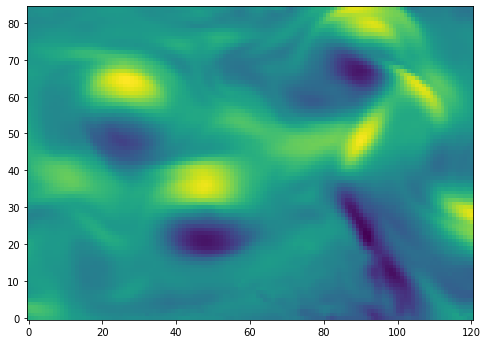

In [2]:
# set area
area="GoM"
if area == "area1":
    # Area 1
    data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
    files = os.listdir(data_dir)
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120), latitude=slice(15,32))
elif area == "GoM":
    # GoM
    data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/GoM"
    files = os.listdir(data_dir)
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-95, -85), latitude=slice(22,29))
else:
    print("Area name is invalid!")
    data = None

modes, eigvals, proj_coeffs, data, orig_data_shape = perform_POD(data, "utotal", 6)

# plot one snapshot
fig = plt.figure(figsize=(8, 8))
print(data.shape)
plt.imshow(data[:, 0].reshape(orig_data_shape[1:]), origin="lower")

In [3]:
# save all frames of original data to make gif
for i in range(data.shape[1]):
    plt.imsave(f"/home/jonas/Downloads/plots/data_gif/{str(i).zfill(4)}.png", data[:, i].reshape(orig_data_shape[1:]), origin="lower")

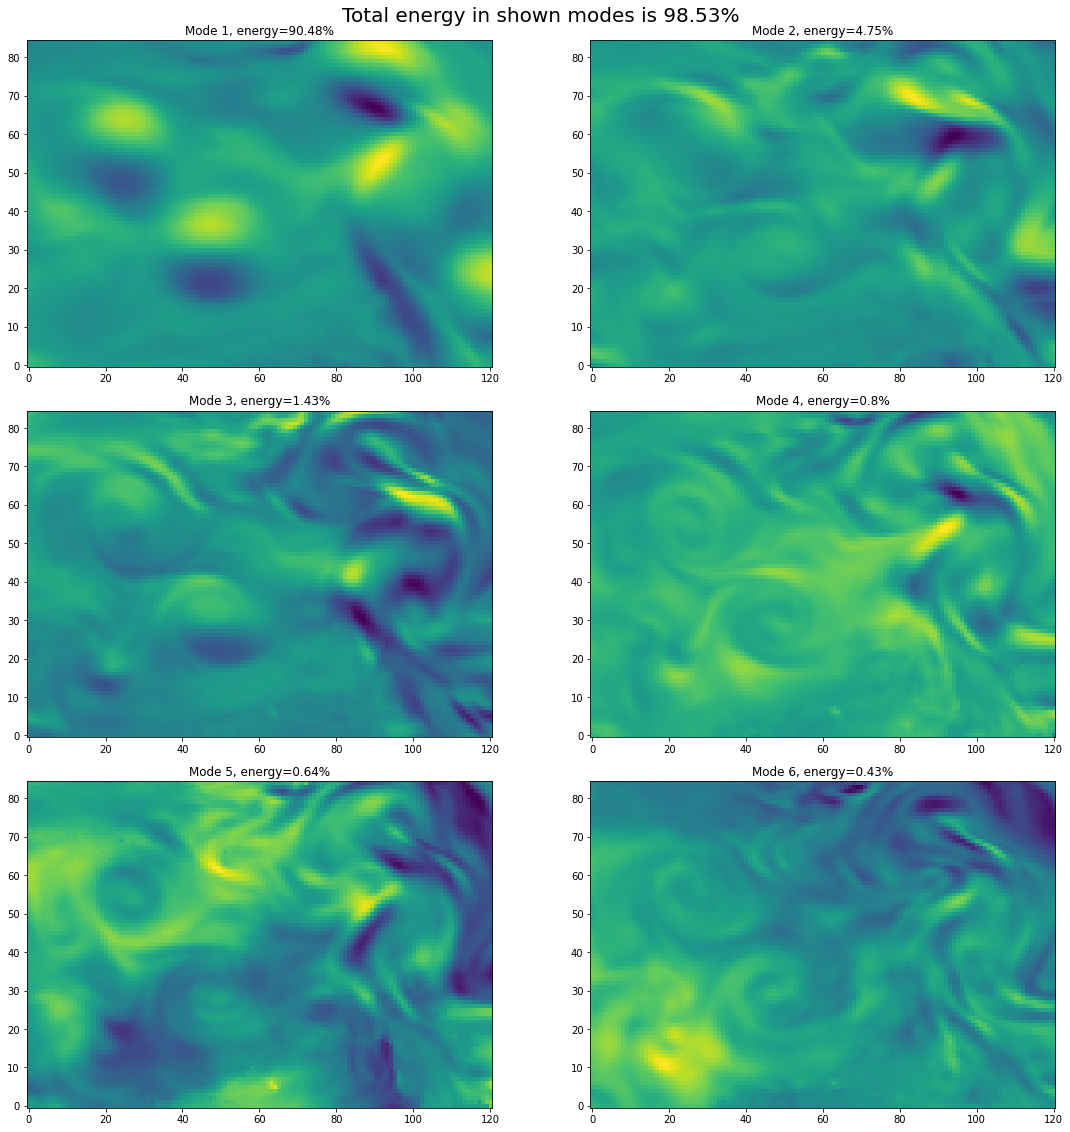

In [4]:
sum_eigvals = eigvals.sum()
normalized_eigvals = eigvals/sum_eigvals

fig, axs = plt.subplots(int(modes.shape[1]/2), 2, figsize=(16, 16))
for i in range(modes.shape[1]):
    ax = axs[int(i//2), i%2]
    ax.imshow(modes[:, i].reshape(orig_data_shape[1:]), origin="lower")
    ax.set_title(f"Mode {i+1}, energy={round(normalized_eigvals[i]*100, 2)}%")
fig.suptitle(f"Total energy in shown modes is {round(normalized_eigvals[:modes.shape[1]].sum()*100, 2)}%", fontsize=20)
plt.tight_layout()
plt.show()

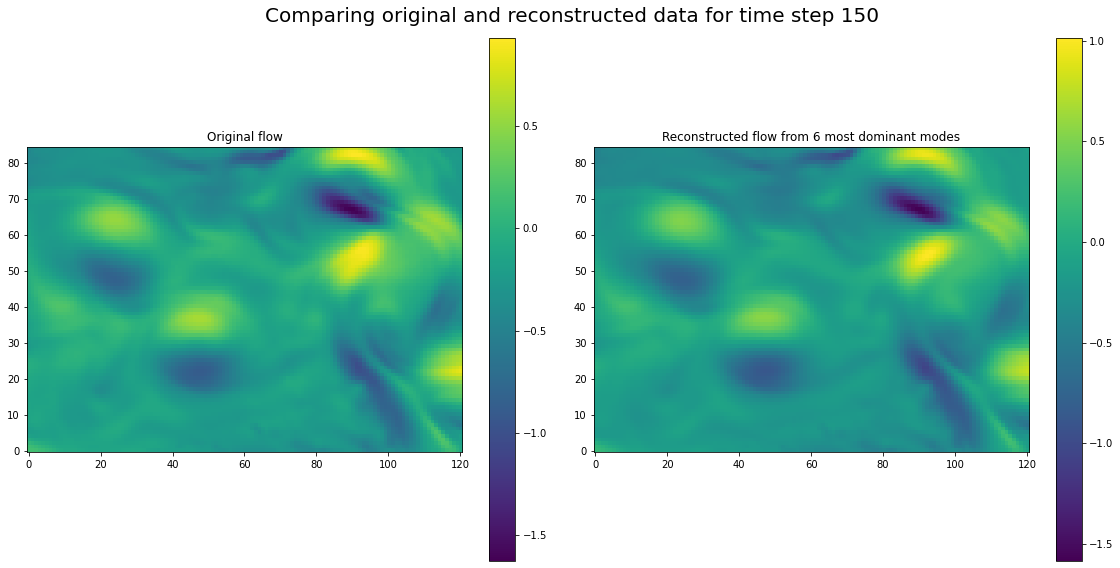

In [5]:
time_step = 150

# plot original data
fig, axs = plt.subplots(1, 2, figsize=(16,8))
img1 = axs[0].imshow(data[:, time_step].reshape(orig_data_shape[1:]), origin="lower")
axs[0].set_title("Original flow")
plt.colorbar(img1, ax=axs[0])

# proj coeffs are of shape [mode x time] -> whole column for first time step
reconstructed_currents = np.zeros_like(modes[:, 0])
for i in range(modes.shape[1]):
    scaling = proj_coeffs[i, time_step]
    reconstructed_currents += modes[:, i] * scaling

# plot reconstruction
img2 = axs[1].imshow(reconstructed_currents.reshape(orig_data_shape[1:]), origin="lower")
axs[1].set_title("Reconstructed flow from 6 most dominant modes")
plt.colorbar(img2, ax=axs[1])

fig.suptitle(f"Comparing original and reconstructed data for time step {time_step}", fontsize=20)
plt.tight_layout()
plt.show()

## Try compressed sensing with forecast first

##### Compressed sensing optimization

$$ \min_s || C\Psi s - y ||_2 + \lambda ||s||_1 $$

$$ x = \Psi s $$

where C is the sampling matrix and Psi is the linear transformation that maps from the sample domain to the domain the original signal can be represented in sparsely.

Loaded 97 days or forecasts
Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (2328, 121, 241)
Shape of input data: (29161, 2328) [flattened space x time snapshots]
Number of modes used: 200.
Number of measurements: 29.


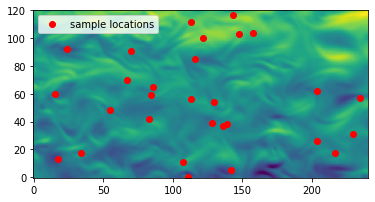

In [71]:
from ocean_navigation_simulator.generative_error_model.compressed_sensing.compressed_sensing import perform_POD

data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
files = sorted(os.listdir(data_dir))

load_all_data = True

if load_all_data:
    # load all forecasts for area 1
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120),
                                                                 latitude=slice(20, 30))
    if len(files) > 1:
        data = data.isel(time=slice(0, 24))
        for file in range(1, len(files)):
            data_temp = xr.open_dataset(os.path.join(data_dir, files[file])).sel(longitude=slice(-140, -120), latitude=slice(20,30))
            data = xr.concat([data, data_temp.isel(time=slice(0, 24))], dim="time")

    print(f"Loaded {round(len(data['time'])/24)} days or forecasts")

else:
    # load one forecast for area 1
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120), latitude=slice(20,30))

# get most dominant modes from FC
num_modes = data["utotal"].values.shape[0]
num_modes = 200
modes, eigvals, proj_coeffs, data, orig_data_shape = perform_POD(data, "utotal", num_modes)
print(f"Number of modes used: {num_modes}.")

# sample from forecast frame
fc_frame = data[:, 0].reshape(orig_data_shape[1:])

# sample from fc frame and get sample vector y
np.random.seed(12345678)
num_samples = int(0.001 * np.prod(fc_frame.shape))
print(f"Number of measurements: {num_samples}.")
samples_idx = np.random.choice(np.prod(fc_frame.shape), num_samples, replace=False)
y = fc_frame.flat[samples_idx]

# plot fc frame and samples
plt.imshow(fc_frame, origin="lower")
plt.scatter(samples_idx%orig_data_shape[2], samples_idx//orig_data_shape[2], color="r", label="sample locations")
plt.legend()
plt.show()

# Set Psi
Psi = modes

# setup C
C = np.zeros((num_samples, np.prod(fc_frame.shape)))
one_indices = np.array([[row, col] for row, col in zip(range(num_samples), samples_idx)])
C[one_indices[:, 0], one_indices[:, 1]] = 1

# construct A matrix
A = C @ Psi

# perform CS
vx = cvx.Variable(A.shape[-1])
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A @ vx == y]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=False)
basis_coeffs = np.array(vx.value)

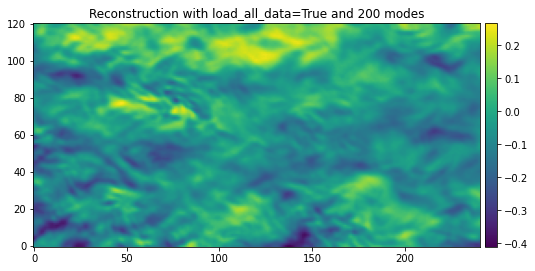

In [72]:
reconstructed_fc = np.dot(Psi, basis_coeffs)
reconstructed_fc = reconstructed_fc.reshape(orig_data_shape[1:])

fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
plt.title(f"Reconstruction with load_all_data={load_all_data} and {num_modes} modes")
img = ax.imshow(reconstructed_fc, origin="lower")
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(img, cax=cax)
plt.show()

In [60]:
# compute RMSE between real and reconstructed
error = fc_frame.reshape(orig_data_shape[1:]) - reconstructed_fc
rmse = np.sqrt((error**2).mean())
print(f"RMSE: {round(rmse, 4)}.")

RMSE: 0.1219.


## Try compressed sensing with buoy values

In [10]:
from ocean_navigation_simulator.generative_error_model.compressed_sensing.compressed_sensing import reconstruct_currents
import os

data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data"
forecast_dir = os.path.join(data_dir, "forecasts/area1")
buoy_data_dir = os.path.join(data_dir, "dataset_forecast_error/area1")
save_dir = os.path.join(data_dir, "cs_data")

reconstruct_currents(forecast_dir, buoy_data_dir, 200, 500, save_dir, "new_cs_gt.nc")

Loaded 97 days of forecasts
Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (2328, 121, 241)
Shape of input data: (29161, 2328) [flattened space x time snapshots]
Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (2328, 121, 241)
Shape of input data: (29161, 2328) [flattened space x time snapshots]
Finished computation and saved file.


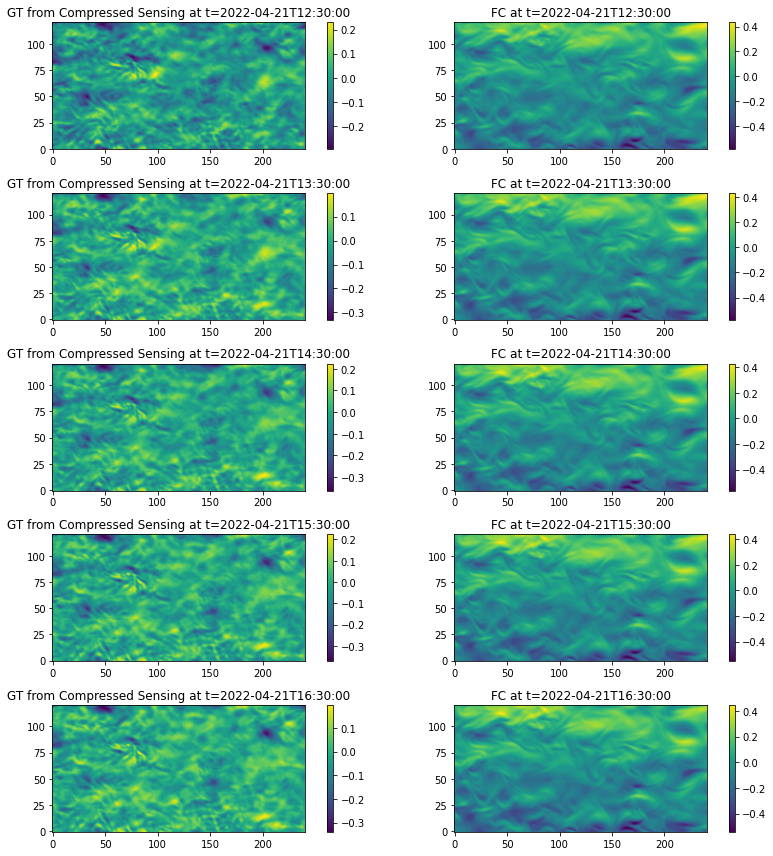

In [19]:
# load CS data
save_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/cs_data"
cs_data = xr.load_dataset(os.path.join(save_dir, "new_cs_gt.nc"))

# load forecast
files = sorted(os.listdir(forecast_dir))
fc_data = xr.open_dataset(os.path.join(forecast_dir, files[0])).sel(longitude=slice(-140, -120),latitude=slice(20, 30))
if len(files) > 1:
    fc_data = fc_data.isel(time=slice(0, 24))
    for file in range(1, len(files)):
        data_temp = xr.open_dataset(os.path.join(forecast_dir, files[file])).sel(longitude=slice(-140, -120), latitude=slice(20, 30))
        fc_data = xr.concat([fc_data, data_temp.isel(time=slice(0, 24))], dim="time")


fig, axs = plt.subplots(5, 2, figsize=(12,12))
for row in range(axs.shape[0]):
    cs_frame = cs_data.isel(time=row)["utotal"]
    time = fc_data.isel(time=row)["time"].values
    time = datetime.datetime.utcfromtimestamp(int(time.astype(datetime.datetime)/1e9))
    time = time.strftime('%Y-%m-%dT%H:%M:%S')
    img1 = axs[row, 0].imshow(cs_frame, origin="lower")
    plt.colorbar(img1, ax=axs[row, 0])
    axs[row, 0].set_title(f"GT from Compressed Sensing at t={time}")

    fc = fc_data.isel(time=row)["utotal"].squeeze()
    time = fc_data.isel(time=row)["time"].values
    time = datetime.datetime.utcfromtimestamp(int(time.astype(datetime.datetime)/1e9))
    time = time.strftime('%Y-%m-%dT%H:%M:%S')
    img2 = axs[row, 1].imshow(fc, origin="lower")
    plt.colorbar(img2, ax=axs[row, 1])
    axs[row, 1].set_title(f"FC at t={time}")
    plt.tight_layout()

In [ ]:
from ocean_navigation_simulator.generative_error_model.Dataset import Dataset
from ocean_navigation_simulator.generative_error_model.generative_model_metrics import rmse_over_time_xr, rmse_over_time

# load CS data
save_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/cs_data"
cs_data = xr.load_dataset(os.path.join(save_dir, "new_cs_gt.nc"))

# load forecast
files = sorted(os.listdir(forecast_dir))
fc_data = xr.open_dataset(os.path.join(forecast_dir, files[0])).sel(longitude=slice(-140, -120),latitude=slice(20, 30))
if len(files) > 1:
    fc_data = fc_data.isel(time=slice(0, 24))
    for file in range(1, len(files)):
        data_temp = xr.open_dataset(os.path.join(forecast_dir, files[file])).sel(longitude=slice(-140, -120), latitude=slice(20, 30))
        fc_data = xr.concat([fc_data, data_temp.isel(time=slice(0, 24))], dim="time")

# compute cs errors
fc_data = fc_data.rename({"longitude": "lon",
                            "latitude": "lat"})

time_range = [fc_data["time"].values.min(), fc_data["time"].values.max()]

fc_data = fc_data.sel(lon=slice(-140, -120),
                      lat=slice(20, 30),
                      time=slice(*time_range[:500]))

cs_data["lon"] = cs_data["lon"].astype(np.float32)
cs_data["lat"] = cs_data["lat"].astype(np.float32)
cs_data["utotal"] = cs_data["utotal"].astype(np.float32)
cs_data["vtotal"] = cs_data["vtotal"].astype(np.float32)

cs_error = fc_data - cs_data
cs_rmse = rmse_over_time_xr(cs_error, variables=("utotal", "vtotal"))

# empirical errors
dataset = Dataset("data/drifter_data", "forecast", "area1")
empirical_errors = dataset.load_dataset(overlap=False, verbose=False)
empirical_rmse = rmse_over_time(empirical_errors, variables=("u_error", "v_error"))["rmse"]

plt.plot(cs_rmse, label="cs RMSE")
plt.plot(empirical_rmse[:len(cs_rmse)], label="empirical RMSE")
plt.ylim([0, 1])
plt.legend()
plt.show()

Loaded area1 from forecasts.


## Load synthetic CS data and sample sparsely to construct variogram

In [16]:
# load saved data for the current errors (~20 days worth)
save_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/cs_data"
data = xr.load_dataset(os.path.join(save_dir, "cs_error.nc"))

In [16]:
# when sampling throw away NaN values
lon_len = len(data["lon"].values)
lat_len = len(data["lat"].values)
time_len = len(data["time"].values)
total_len = lon_len * lat_len * time_len

idx = np.random.choice(list(range(total_len)), size=300000)

lon = data["lon"].values.reshape(-1)
lat = data["lat"].values.reshape(-1)
time = data["time"].values.reshape(-1)

axes = np.array(list(itertools.product(lon, lat, time)))[idx]
lon = axes[:, 0]
lat = axes[:, 1]
time = axes[:, 2]
u_error = data["u_error"].values.reshape(-1)[idx]

data = pd.DataFrame({"lon": lon,
                     "lat": lat,
                     "time": time,
                     "u_error": u_error,
                     "v_error": u_error})

data = data.dropna()
print(data)
data.to_csv(os.path.join(save_dir, "sparse_error.csv"))

               lon        lat                time   u_error   v_error
0      -133.666667  22.416667 2022-05-11 07:30:00 -0.069761 -0.069761
1      -126.666667       27.0 2022-05-10 11:30:00 -0.009497 -0.009497
2      -120.083333      22.25 2022-04-25 01:30:00 -0.032816 -0.032816
3          -128.75  28.166667 2022-05-02 07:30:00 -0.084601 -0.084601
4      -137.416667  22.416667 2022-04-22 20:30:00 -0.007031 -0.007031
...            ...        ...                 ...       ...       ...
299995 -136.333333  28.916667 2022-05-06 09:30:00 -0.078564 -0.078564
299996 -131.416667      20.25 2022-05-10 17:30:00  0.010882  0.010882
299997 -120.083333       25.0 2022-05-09 16:30:00 -0.053906 -0.053906
299998 -122.583333       28.5 2022-05-09 23:30:00 -0.148472 -0.148472
299999 -125.333333  20.666667 2022-05-10 00:30:00 -0.075602 -0.075602

[300000 rows x 5 columns]



Loaded config at: /home/jonas/Documents/Thesis/OceanPlatformControl/scenarios/generative_error_model/config_buoy_data.yaml.

Loaded variogram from: 2022-09-20_19:59:00_2d_forecast_variogram_area1_[5.0, 1.0]_False_True.npy.
Resolution: [5.0, 1.0] km.
Number of pairs: 4999950000.


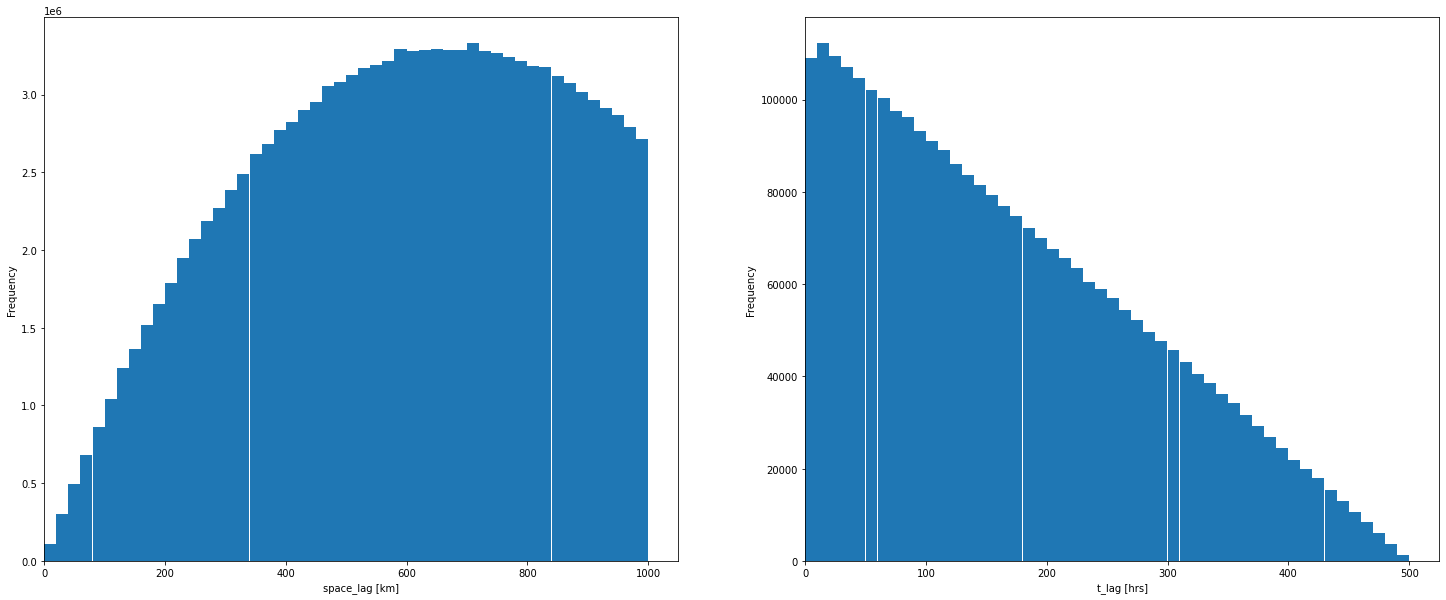

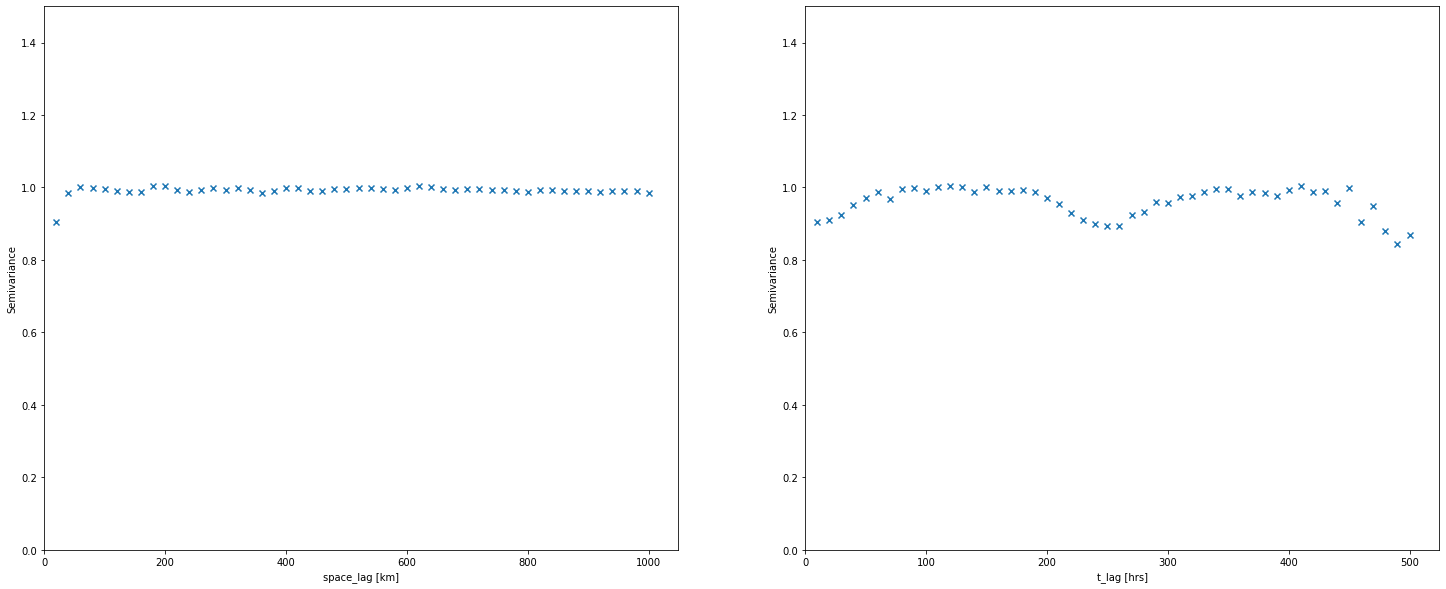

In [14]:
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram
from ocean_navigation_simulator.generative_error_model.utils import load_config

config = load_config("config_buoy_data.yaml")

variogram_file = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/cs_data/2022-09-20_19:59:00_2d_forecast_variogram_area1_[5.0, 1.0]_False_True.npy"
vvis = VisualizeVariogram()
vvis.read_variogram_from_file(variogram_file)
vvis.decrease_variogram_res((20, 10))
view_range = [1000, 500]
vvis.plot_histograms(view_range=view_range)
vvis.plot_variograms(view_range=view_range)